# Pipeline машинного обучения

## Порядок и критерии успешной реализации проекта

В рамках проекта необходимо реализовать следующие пункты:

1. [Построение моделей на числовых признаках](#Построение-моделей-на-числовых-признаках) (**1 балл**):
  * минимум - NB и kNN, максимум - любые,
  * построение моделей на числовых признаках с параметрами по умолчанию,
  * вычисление метрик + комментарий о качестве моделей.
2. [Подбор гиперпараметров каждой из моделей](#Подбор-гиперпараметров-каждой-из-моделей) (**3 балла**):
  * подбор гиперпараметров у каждой из моделей (только на числовых признаках) при помощи GridSearchCV,
  * вычисление метрик для лучших найденных моделей,
  * текстовый комментарий.
3. [Добавление категориальных признаков в лучшую модель](#Добавление-категориальных-признаков-в-лучшую-модель) (**2 балла**):
  * добавление категориальных признаков в лучшую модель,
  * обучение модели,
  * заново подбор её гиперпараметров,
  * вычисление метрик,
  * текстовый комментарий.
4. [Построение _Explainer Dashboard_](#Построение-Explainer-Dashboard) (**1 балл**)
  *  сохранение файла с дашбордом на _GitHub_
5. [Анализ модели в _Explainer Dashboard_](#Анализ-модели-в-Explainer-Dashboard):
  * какие факторы наиболее важны в среднем для получения прогноза? (**1 балл**)
  * какие значения метрик получились и что это значит? (**1 балл**)
  * анализ 2-3 индивидуальных прогнозов с комментарием (**1 балл**).

## Подход к моделированию
Целью, которую необходимо достичь с помощью алгоритмов машинного обучения, является подсчёт возраста моллюска галиолиса. Возраст, согласно условию, соотносится с числом колец примерно как 1 к 1,5. Тем самым необходимо спрогнозировать число колец по иным признакам. 

Достигаемая цель любого моделирования - расчёт наиболее оптимальной метрики качества - решается без указания конкретной метрики. Целевой признак `rings` (число колец раковины _галиолиса_) является целочисленным, следовательно моделированием решается задача регрессии. Таким образом, помимо `Наивного байесовского классификатора` и `Метода ближайшего соседа` используем ещё одну модель, например, `Дерева решений`. Ввиду этого порядок выполнения моделирования будет следующим:
1. подготовка датасета (очистка от коррелирующих признаков)
2. выделение из датасета тестовой и обучающей выборок
3. обучение 3-х моделей, их тестирование и подсчёт метрики качества
4. подбор гиперпараметров с помощью _GridSearchCV_ для 3-х моделей и вычисление метрик качества
5. перевод категориального признака в лучшую модель

### Импорт библиотек машинного обучения

In [1]:
!pip install scikit-learn
!pip install shap -q
!pip install plotly
!pip install explainerdashboard -q

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
import shap
from sklearn.inspection import permutation_importance as pi
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Подготовка обучающего датасета
Ранее был подготовлен датасет, предварительно очищенный от выбросов и аномальных значений. Однако на основе [матрицы корреляции для количественных признаков](#Матрицы-корреляции-для-количественных-признаков) можно сделать вывод об избыточности использования всех признаков очищенного датасета `data_cl`. Числовые признаки у нас делятся на две условные категории: габариты и масса. _Матрица корреляции Спирмена_ чётко демонстрирует сильную корреляцию между признаками `diameter` и `lenght` для габаритных показателей. А для показателей массы характерна сильная корреляция между признаком `whole_weight` (_масса целого моллюска в граммах_) и `shucked_weight` (_масса мяса в граммах_) / `viscera_weight` (_масса потрохов в граммах_). 

Ввиду этого принимаем решение в дальнейшем обучении использовать только признак `diameter` и признак `whole_weight` из перечня указанных. Остальные признаки оставим, как есть.

In [3]:
data_cl = pd.read_csv('abalone_cl.csv')
data_cl.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.4410,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
# установка начального значения генератора случайных чисел в ходе обучения
np.random.seed(42)

In [5]:
data_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4109 entries, 0 to 4108
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4109 non-null   object 
 1   length          4109 non-null   float64
 2   diameter        4109 non-null   float64
 3   height          4109 non-null   float64
 4   whole_weight    4109 non-null   float64
 5   shucked_weight  4109 non-null   float64
 6   viscera_weight  4109 non-null   float64
 7   shell_weight    4109 non-null   float64
 8   rings           4109 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 289.0+ KB


In [6]:
# матрица признаков
X = data_cl[['diameter', 'height', 'whole_weight', 'shell_weight']]

# вектор целевых (таргетированных) признаков
y = data_cl['rings']

### Разбиение на возрастные группы
Согласно докладу [СТРУКТУРА, СОВРЕМЕННОЕ СОСТОЯНИЕ И ПЕРСПЕКТИВЬI ВОСПРОИЗВОДСТВА ПОПУЛЯЦИИ ГАЛИОТИСА ОСТРОВА МОНЕРОН](http://aquacultura.org/upload/files/pdf/biblio/invert/Переладов_1999.pdf) можно сформировать деление галиотиса по группам плодонесения (принесения потомства). Так моллюск начинает плодоносить в возрасте 2-3 лет (крайнее число колец посчитаем в 4) и продолжает до 8-10 лет (15 колец). В этом возрасте он достигает половой зрелости и может производить потомство. Однако, в некоторых условиях, галиотис может жить более 20 лет.

На основании выводов, сделанных в ходе анализа [графика плотности распределения колец раковин](#График-плотности-распределения-колец-раковин) можно разбить значения признака `rings` на классы по числу колец. Это будут группы:
- до 4 колец включительно
- от 5 до 15 колец включительно
- от 15 колец и более

При необходимости можно будет выполнить обучение для данных возрастных групп.

In [7]:
# определение границ диапазонов
bins = [0, 4, 15, 29]

# определение меток для категорий
labels = ['неплодоносные', 'плодоносные', 'старые']

# группировка значений целевого признака по диапазонам
y_class = pd.cut(y, bins=bins, labels=labels, ordered=False)

# проверка результатов группировки
print(y_class.value_counts())

плодоносные      3786
старые            250
неплодоносные      73
Name: rings, dtype: int64


### Выделение выборок
Поскольку изначально у нас отсутствует тестовая выборка, то выделим её из подготовленного датасета `data_cl` в отношении 1:3 к обучающей выборке.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.25)

## Построение моделей на числовых признаках

### Метод наивного Байеса (Naive Bayes)

In [9]:
# определение модели
nb = GaussianNB()

# обучение модели
nb.fit(X_train, y_train)

# предсказание меток классов для тестовых данных
y_pred = nb.predict(X_test)

# расчёт метрик качества
nb_accuracy_score = accuracy_score(y_test.values.ravel(), y_pred)
nb_precision_score = precision_score(y_test.values.ravel(), y_pred, average='micro')
nb_recall_score = recall_score(y_test.values.ravel(), y_pred, average='micro')

print("Метрика качества accurancy_score", nb_accuracy_score)
print("Метрика качества precision_score", nb_precision_score)
print("Метрика качества recall_score", nb_recall_score)

Метрика качества accurancy_score 0.7811284046692607
Метрика качества precision_score 0.7811284046692607
Метрика качества recall_score 0.7811284046692607


### Метод ближайшего соседа (Nearest Neighbor)

In [10]:
# определение модели
knn = KNeighborsClassifier()

# обучение модели
knn.fit(X_train, y_train.values.ravel())

# предсказание меток классов для тестовых данных
y_pred_knn = knn.predict(X_test)

# расчёт метрик качества
knn_accuracy_score = accuracy_score(y_test.values.ravel(), y_pred_knn)
knn_precision_score = precision_score(y_test, y_pred_knn, average='micro')
knn_recall_score = recall_score(y_test, y_pred_knn, average='micro')

print("Метрика качества accurancy_score", knn_accuracy_score)
print("Метрика качества precision_score", knn_precision_score)
print("Метрика качества recall_score", knn_recall_score)

Метрика качества accurancy_score 0.9202334630350194
Метрика качества precision_score 0.9202334630350194
Метрика качества recall_score 0.9202334630350194


### Метод дерева решений

In [11]:
# определение модели
dtc = DecisionTreeClassifier()

# обучение модели
dtc.fit(X_train, y_train)

# предсказание меток классов для тестовых данных
y_pred_dtc = dtc.predict(X_test)

# расчёт метрик качества
dtc_accuracy_score = accuracy_score(y_test.values.ravel(), y_pred_dtc)
dtc_precision_score = precision_score(y_test, y_pred_dtc, average='micro')
dtc_recall_score = recall_score(y_test, y_pred_dtc, average='micro')

print("Метрика качества accurancy_score", dtc_accuracy_score)
print("Метрика качества precision_score", dtc_precision_score)
print("Метрика качества recall_score", dtc_recall_score)

Метрика качества accurancy_score 0.8910505836575876
Метрика качества precision_score 0.8910505836575876
Метрика качества recall_score 0.8910505836575876


По указанным результатам можно сделать несколько промежуточных выводов. Использованные метрики качества для всех трёх моделей машинного обучения возвращают одно значение. Стало быть, в дальнейшем ограничим использование метрики `accurancy_score`. Что касаемо результатов обучения, то для моделей (без подбора гиперпараметров) они низкие. К сожалению, у нас нет более точного представления о конечной цели, поэтому можно оперировать тем, что есть. Возможны следующие причины низкого качества предсказания:

1. недостаточное количество данных для обучения моделей
2. неправильный выбор модели (но у нас результат приблизительно одинаков для трёх разных моделей)
3. неправильная предобработка данных

## Подбор гиперпараметров каждой из моделей
Выполним подбор гиперпараметров с помощью GridSearchCV.

### Метод наивного Байеса (Naive Bayes)

In [12]:
%%time

# Задаём модель
model_nb = GaussianNB()

# Задаем сетку параметров для подбора
param_grid = {
    'var_smoothing': np.logspace(-10, 0, num=100)
             }

# Создаем объект GridSearchCV
gs = GridSearchCV(model_nb, param_grid, cv=3, scoring='accuracy', verbose=1)

# Обучаем модель на обучающей выборке
gs.fit(X_train, y_train)

# Выводим лучшие параметры и значение метрики качества
print()
print(f'Лучшее значение гиперпараметров {gs.best_params_}')
print(f'Лучшее значение метрики качества при указанных значениях гиперпараметров {gs.best_score_}')
print()
# Вычисляем точность на тестовой выборке
pred = gs.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Значение метрики качества на тестовой выборке:', accuracy)
print()

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Лучшее значение гиперпараметров {'var_smoothing': 0.15556761439304723}
Лучшее значение метрики качества при указанных значениях гиперпараметров 0.9266471924699773

Значение метрики качества на тестовой выборке: 0.9241245136186771

CPU times: user 1.96 s, sys: 6.62 ms, total: 1.97 s
Wall time: 1.97 s


### Метод ближайшего соседа (Nearest Neighbor)

In [13]:
%%time
# Задаём модель
model_knn = KNeighborsClassifier()

# Задаем сетку параметров для подбора
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4]
             }

# Создаем объект GridSearchCV
gs = GridSearchCV(model_knn, param_grid, cv=5, scoring='accuracy', verbose=1)

# Обучаем модель на обучающей выборке
gs.fit(X_train, y_train)

print()
print(f'Лучшее значение гиперпараметров {gs.best_params_}')
print(f'Лучшее значение метрики качества при указанных значениях гиперпараметров {gs.best_score_}')
print()
pred = gs.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Значение метрики качества на тестовой выборке:', accuracy)
print()

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Лучшее значение гиперпараметров {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Лучшее значение метрики качества при указанных значениях гиперпараметров 0.9269712054558085

Значение метрики качества на тестовой выборке: 0.9202334630350194

CPU times: user 3.56 s, sys: 7.43 ms, total: 3.57 s
Wall time: 3.56 s


### Метод дерева решений

In [14]:
%%time
# Задаём модель
model_dt = DecisionTreeClassifier()

# Задаем сетку параметров для подбора
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
             }

# Создаем объект GridSearchCV
gs = GridSearchCV(model_dt, param_grid, cv=5, scoring='accuracy', verbose=1)

# Обучаем модель на обучающей выборке
gs.fit(X_train, y_train)

print()
print(f'Лучшее значение гиперпараметров {gs.best_params_}')
print(f'Лучшее значение метрики качества при указанных значениях гиперпараметров {gs.best_score_}')
print()
pred = gs.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Значение метрики качества на тестовой выборке:', accuracy)
print()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Лучшее значение гиперпараметров {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Лучшее значение метрики качества при указанных значениях гиперпараметров 0.9263223810225429

Значение метрики качества на тестовой выборке: 0.9280155642023347

CPU times: user 8.99 s, sys: 2.61 ms, total: 8.99 s
Wall time: 8.99 s


Как и ожидалось, после подбора гиперпараметров для каждой из трёх моделей возвращаются более высокие значения метрик качества, при этом эти значения всё равно низкие. Выделить из результатов наиболее привлекательные достаточно сложно. 

## Добавление категориальных признаков в лучшую модель
Выбрать модель с лучшими значениями метрики качества достаточно сложно, поскольку результаты везде практически идентичны. Они немногим лучше для метода дерева решений. Так что далее использовать будем эту модель.
В целом для чего нужно переводить единственный категориальный признак в количественный также не понял. Ну раз надо, тогда сделаем. Однако далее будет видно, что это даёт ещё более бессмысленные результаты, чем обучение моделей.

In [15]:
X_full = data_cl.drop('rings', axis=1)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_class, test_size=0.25)

X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4109 entries, 0 to 4108
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4109 non-null   object 
 1   length          4109 non-null   float64
 2   diameter        4109 non-null   float64
 3   height          4109 non-null   float64
 4   whole_weight    4109 non-null   float64
 5   shucked_weight  4109 non-null   float64
 6   viscera_weight  4109 non-null   float64
 7   shell_weight    4109 non-null   float64
dtypes: float64(7), object(1)
memory usage: 256.9+ KB


In [16]:
# выделяем категориальный признак
categorical = ['sex']

# количественные признаки
numeric_features = ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', MinMaxScaler(), numeric_features)
])

X_train_transformed = ct.fit_transform(X_train_full)
X_test_transformed = ct.transform(X_test_full)

In [17]:
new_features = list(ct.named_transformers_['ohe'].get_feature_names_out())
new_features.extend(numeric_features)

print('Всего количественных признаков:', new_features)

Всего количественных признаков: ['sex_F', 'sex_I', 'sex_M', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']


In [18]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=new_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=new_features)

X_train_transformed.head()

,sex_F,sex_I,sex_M,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,1.0,0.0,0.0,0.691729,0.679612,0.50,0.344939,0.270671,0.299391,0.266467
1,0.0,0.0,1.0,0.631579,0.650485,0.44,0.294224,0.173897,0.279373,0.291417
2,0.0,1.0,0.0,0.383459,0.349515,0.34,0.076072,0.058584,0.055701,0.061876
3,1.0,0.0,0.0,0.857143,0.893204,0.76,0.724089,0.608083,0.635335,0.510978
4,1.0,0.0,0.0,0.616541,0.611650,0.56,0.275106,0.202818,0.237598,0.211577


In [19]:
%%time
# Задаём модель
model_dt = DecisionTreeClassifier()

# Задаем сетку параметров для подбора
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
             }

# Создаем объект GridSearchCV
gsb = GridSearchCV(model_dt, params, cv=5, scoring='accuracy', verbose=1)

# Обучаем модель на обучающей выборке
gsb.fit(X_train_transformed, y_train_full)

print()
print(f'Лучшее значение гиперпараметров {gsb.best_params_}')
print(f'Лучшее значение метрики качества при указанных значениях гиперпараметров {gsb.best_score_}')
print()
# Вычисляем точность на тестовой выборке
pred_best = gsb.best_estimator_.predict(X_test_transformed)
accuracy_best = accuracy_score(y_test_full, pred_best)
print('Значение метрики качества на тестовой выборке:', accuracy_best)
print()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Лучшее значение гиперпараметров {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
Лучшее значение метрики качества при указанных значениях гиперпараметров 0.9315166600012628

Значение метрики качества на тестовой выборке: 0.9163424124513618

CPU times: user 10.8 s, sys: 682 µs, total: 10.8 s
Wall time: 10.8 s


## Построение _Explainer Dashboard_
### Permutation Importance

In [29]:
X_train_transformed.shape

(3081, 10)

[2024-01-17 17:22:54,488] ERROR in app: Exception on /_dash-component-suites/plotly/package_data/plotly.min.js [GET]
Traceback (most recent call last):
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 1455, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 869, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 867, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 852, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/elijah/.local/lib/python3.10/site-packages/dash/dash.py", line 962, in serve_component_suites
    pkgutil.get_data(package_name, path_in_pkg), mimetype=mimetype
  File "/usr/lib/python3.10/pkgutil.py", line 639, in get_data
    re

Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []


[2024-01-17 17:26:18,691] ERROR in app: Exception on /_dash-component-suites/plotly/package_data/plotly.min.js [GET]
Traceback (most recent call last):
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 1455, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 869, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 867, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 852, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/elijah/.local/lib/python3.10/site-packages/dash/dash.py", line 962, in serve_component_suites
    pkgutil.get_data(package_name, path_in_pkg), mimetype=mimetype
  File "/usr/lib/python3.10/pkgutil.py", line 639, in get_data
    re

Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []


[2024-01-17 17:52:56,286] ERROR in app: Exception on /_dash-component-suites/plotly/package_data/plotly.min.js [GET]
Traceback (most recent call last):
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 1455, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 869, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 867, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/elijah/.local/lib/python3.10/site-packages/flask/app.py", line 852, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/elijah/.local/lib/python3.10/site-packages/dash/dash.py", line 962, in serve_component_suites
    pkgutil.get_data(package_name, path_in_pkg), mimetype=mimetype
  File "/usr/lib/python3.10/pkgutil.py", line 639, in get_data
    re

Text(0.5, 0, 'Permutation Importance')

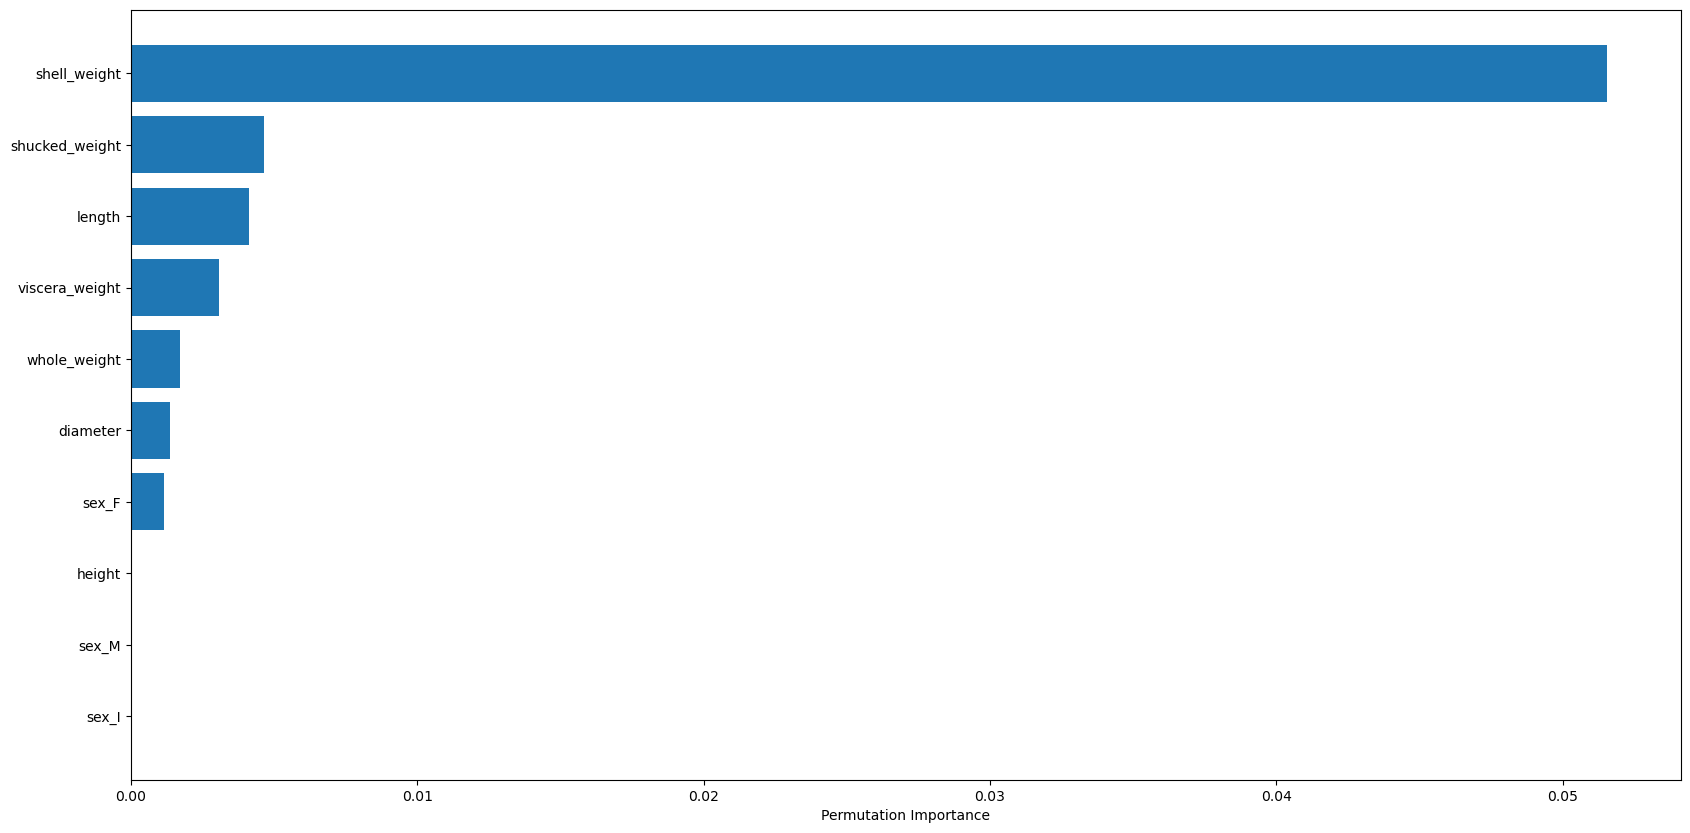

In [21]:
plt.figure(figsize=(20,10))
result = pi(
    gsb.best_estimator_, 
    X_train_transformed, 
    y_train_full, 
    n_repeats=10, 
    random_state=0
                               )
sorted_idx = result.importances_mean.argsort()
plt.barh(
    X_train_transformed.columns[sorted_idx], 
    result.importances_mean[sorted_idx]
        )
plt.xlabel("Permutation Importance")

Из получившейся диаграммы видно, что наиболее важным признаком для модели является `shell_weight`, так как его значение Permutation Importance значительно больше, чем у остальных признаков. Остальные признаки имеют промежуточную важность для модели. Эта информация может быть полезна для дальнейшего улучшения модели путем удаления неважных признаков или добавления новых.

### Shapley values

In [22]:
X_train_transformed.shape

(3081, 10)

Using 3081 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/150 [00:00<?, ?it/s]

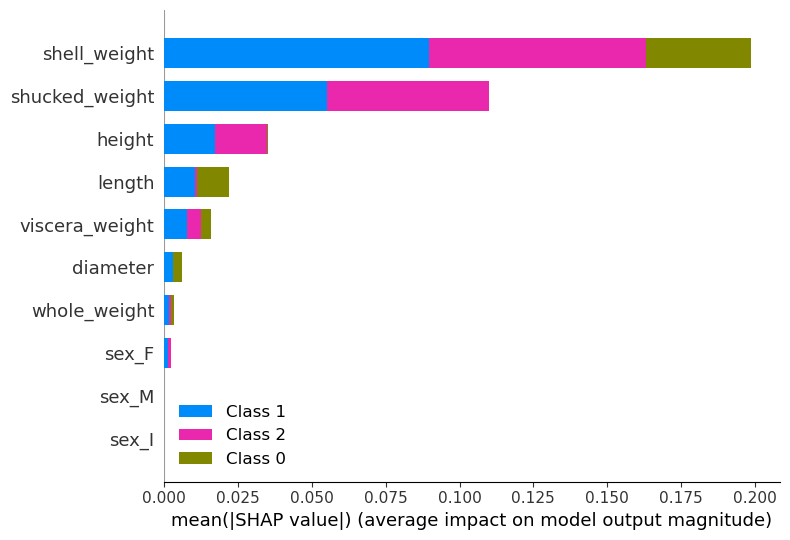

In [23]:
# Создаем экземпляр модели с лучшими гиперпараметрами
model_best_dt = gsb.best_estimator_

# Обучаем модель на полном тренировочном наборе данных
model_best_dt.fit(X_train_transformed, y_train_full)

# Создаем объект explainer для вычисления Shapley Values
explainer = shap.KernelExplainer(model_best_dt.predict_proba, X_train_transformed)

# Вычисляем Shapley Values для всех объектов из тестовой выборки
shap_values = explainer.shap_values(X_test_transformed.iloc[:150,:])

# Визуализируем результаты
shap.summary_plot(shap_values, X_test_transformed.iloc[:150,:])

Если честно, пока пытался подобрать нормальные метрики моделей, уже позабыл, что это за показатель такой shapley values, так что мне сложно интерпретировать данный график.

## Анализ модели в _Explainer Dashboard_

In [24]:
# преобразовываем категориальные значения целевого признака в числовые
y_test_encoded, y_test_categories = pd.factorize(y_test_full)

In [25]:
forest_explainer = ClassifierExplainer(gsb.best_estimator_, X_test_transformed, y_test_encoded)

Note: model_output=='probability', so assuming that raw shap output of DecisionTreeClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)


В общем-то дашборд не строится, куча ошибок. Ошибка `Recall is ill-defined and being set to 0.0 due to no true samples` возникает, когда в тестовой выборке отсутствуют объекты с определенным классом. Чтобы избежать этой ошибки, необходимо убедиться, что в тестовой выборке присутствуют объекты всех классов.

Ошибка `ValueError: Only one class present in y_true. ROC AUC score is not defined in that case`. возникает, когда в тестовой выборке присутствует только один класс. Чтобы избежать этой ошибки, необходимо убедиться, что в обучающей выборке присутствуют объекты всех классов. Но у нас изначально был всего один категориальный признак, следовательно сложно представить, что ещё нужно сделать.

In [26]:
db = ExplainerDashboard(forest_explainer)

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions..

In [27]:
report = classification_report(y_test_full, y_pred) #, zero_division=1.0)
print(report)

               precision    recall  f1-score   support

неплодоносные       0.00      0.00      0.00        18
  плодоносные       0.92      0.78      0.84       944
       старые       0.04      0.11      0.06        66

     accuracy                           0.72      1028
    macro avg       0.32      0.29      0.30      1028
 weighted avg       0.84      0.72      0.78      1028



In [28]:
db.run()

Starting ExplainerDashboard on http://10.0.30.107:8050
